In [1]:
import numpy as np
import scipy.signal as sig
import scipy.io
import os
import librosa
import sys

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', size=10)
plt.rc('font', family='serif')
cm = 2.54
# setting path
sys.path.append("../")
from Utils.dB import *
from HN_decomposition.Subspace.preprocessing import *
def RMS(x):
        return np.std(x)

## Sub-band decomposition

(92287,)


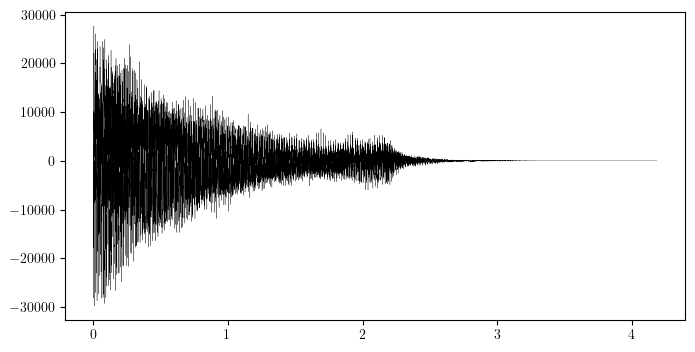

In [2]:

def filter_n_decimate(filterLength_smp : int, numBands : int, inputSignal : np.array):
    """
    args :
        - filterLength : [int]
            Digital filter length, in samples
        - numBands : [int]
            Number of frequency channels in which the signal is to be separated
        - inputSignal : [(1, N) np.array]
            Input signal 
    returns :
        - outputSignals : [(numBands, N) np.array]
            Output signal"""
    signalLength_smp = np.shape(inputSignal)[0] #Input signal length
    filteredSignal = np.zeros((signalLength_smp, numBands)) #initializing the output signal
    
    #h = scipy.signal.remez(numtaps = filterLength_smp, bands = [0, 1/(2*numBands), 1/(2*numBands), .5], fs = 1)

    for i in range(numBands):
        filteredSignal[:,i] = inputSignal

    filters = np.zeros((filterLength_smp, numBands))

    n = np.arange(filterLength_smp)
    base_filter = np.zeros(filterLength_smp)
    for i in range(filters):
        filters[i] = base_filter
    
    outputSignal = filteredSignal[::numBands]
    return outputSignal


sr_hz, x = scipy.io.wavfile.read(os.path.join("..", "Data", "Piano_test", "33.wav"))

#y = filter_n_decimate(15, 4, x)


print(np.shape(x))
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(x))/sr_hz, x, 'k', linewidth = .2)
plt.show()

In [26]:
rankFilter_bins = 51
rankFilter_rank = .3

In [27]:
x, sr_hz = librosa.load(os.path.join("..", "Data", "Piano_test", "33_shortened.wav"))

n_fft = 512
hop_length = n_fft//4

x_stft = librosa.stft(x ,n_fft = n_fft, hop_length = hop_length, center=False)

xRankFiltered_stft = rankFilter_stft(x_stft, rankFilter_bins = rankFilter_bins, rankFilter_rank = rankFilter_rank)

t_list = librosa.frames_to_samples(np.arange(np.shape(x_stft)[1]), n_fft = n_fft, hop_length=hop_length)/sr_hz
f_list = librosa.fft_frequencies(sr = sr_hz, n_fft = n_fft)

print(f'sample rate : {sr_hz}')

#plt.pcolormesh(t_list, f_list, dB10(X), vmax = 40, vmin = -60, cmap = 'gray_r')
#plt.colorbar()
#plt.show()

sample rate : 22050


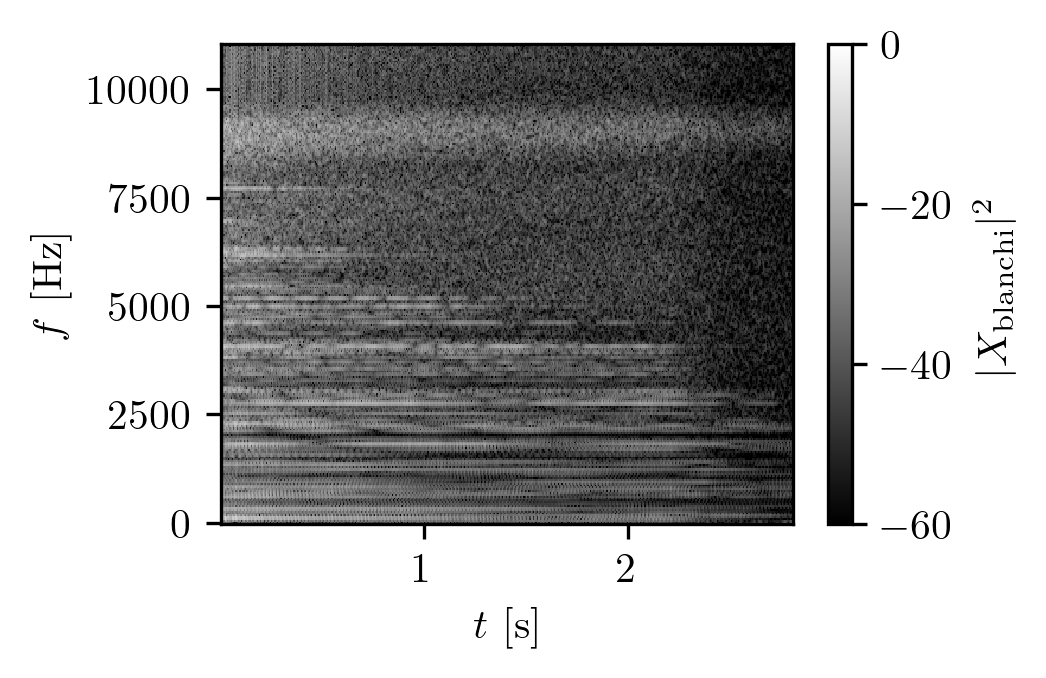

In [28]:
window_type = 'hann'
xWhitened = whiten_stft(
    x = x,
    n_fft = n_fft,
    hop_length = hop_length,
    rankFilter_bins = rankFilter_bins,
    rankFilter_rank = rankFilter_rank,
    ARFilter_length = 12,
    window_type=window_type)
xWhitened_stft = compute_stft_from_whitened(xWhitened, window_type=window_type)


cmap = 'gray'
dpi = 300
figsize = (9/cm, 6/cm)

plt.figure(figsize = figsize, dpi = dpi)
plt.pcolormesh(t_list, f_list, dB20(x_stft), cmap = cmap, vmax = 20, vmin = -100, rasterized=True)
plt.xlabel("$t$ [s]")
plt.ylabel("$f$ [Hz]")
plt.colorbar(label = '$|X|^2$')
plt.tight_layout()
plt.savefig(fname = os.path.join("..", "..", "PAM_overleaf", "Notes", "HR", "Figures", "input_stft.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
#plt.show()
plt.close()

plt.figure(figsize = figsize, dpi = dpi)
plt.pcolormesh(t_list, f_list, dB10(xRankFiltered_stft), cmap = cmap, vmax = 20, vmin = -100, rasterized=True)
plt.xlabel("$t$ [s]")
plt.ylabel("$f$ [Hz]")
plt.colorbar(label = '$|N|^2$')
plt.tight_layout()
plt.savefig(fname = os.path.join("..", "..", "PAM_overleaf", "Notes", "HR", "Figures", "noise_stft.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
#plt.show()
plt.close()


plt.figure(figsize = figsize, dpi = dpi)
plt.pcolormesh(t_list, f_list, dB20(xWhitened_stft), cmap = cmap, vmax = 0, vmin = -60, rasterized=True)
plt.xlabel("$t$ [s]")
plt.ylabel("$f$ [Hz]")
plt.colorbar(label = "$|X_{\mathrm{blanchi}}|^2$")
plt.tight_layout()
plt.savefig(fname = os.path.join("..", "..", "PAM_overleaf", "Notes", "HR", "Figures", "whitened_stft.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
plt.show()
plt.close()


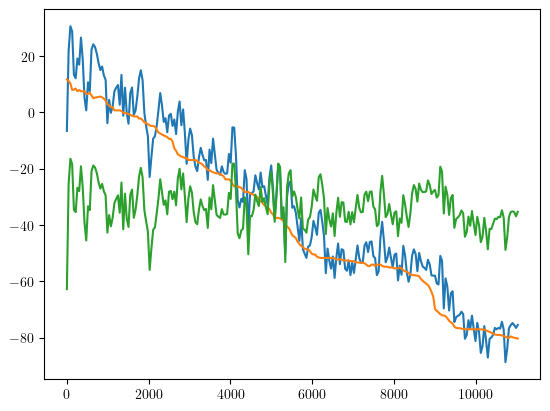

In [29]:
time_frame_display = 41

plt.plot(f_list, dB20(x_stft[:,time_frame_display]))
plt.plot(f_list, dB10(xRankFiltered_stft[:,time_frame_display]))
plt.plot(f_list, dB20(xWhitened_stft[:,time_frame_display]))
plt.show()

In [7]:
AR_order = 12

for t in range(np.shape(X)[1]):
    noise_estimate = np.fft.irfft(X_filt[:,t])

noise_autocorr_vec = np.fft.irfft(X_filt[:,time_frame_display])[:AR_order+1]
#noise_autocorr_vec/=noise_autocorr_vec[0]

R = scipy.linalg.toeplitz(noise_autocorr_vec[:AR_order])
r = noise_autocorr_vec[1: AR_order+1]

AR_filt = np.concatenate((np.ones(1), -np.dot(scipy.linalg.inv(R), r)))*100
#AR_filt = np.dot(scipy.linalg.inv(R), r)
AR_sig = np.zeros(np.shape(X)[0])
AR_sig[0] = 1
AR_sig = sig.lfilter([1], AR_filt, AR_sig)
#AR_sig = sig.lfilter(AR_filt[:], [1], AR_sig)


plt.figure(figsize = (9/cm, 6/cm))
plt.plot(f_list, dB20(X[:,time_frame_display]), linewidth = .5, label = "input", color = (.5,.5,.5))
plt.plot(f_list, dB10(X_filt[:,time_frame_display]), 'k--', linewidth = .5, label = "median")
plt.plot(f_list, dB20(np.fft.rfft(AR_sig, n = n_fft)), 'k-', linewidth = .5, label = 'AR filter')

plt.xlabel(r"$f$ [Hz]")
plt.ylabel(r"$|X|$ [dB]")
plt.tight_layout()
plt.legend(loc = 'upper right')

plt.savefig(fname = os.path.join("..", "..", "PAM_overleaf", "Notes", "Come", "Figures", "filtered_spectrum.pgf"), dpi = 300, bbox_inches = "tight", format = "pgf")
plt.show()

#def fit(self, p=5):
#    ac = self.autocorr(p+1)
#    R = linalg.toeplitz(ac[:p])
#    r = ac[1:p+1]
#    self.phi = linalg.inv(R).dot(r)


plt.plot(noise_autocorr_vec)
plt.xlabel("$k$")
plt.ylabel("$R_{xx}(k)$")
plt.show()

NameError: name 'X' is not defined

In [ ]:
help(scipy.signal.lfilter)

In [ ]:
help(plt.savefig)